# Project: House Price Prediction in Nepal

Problem Definition:
- Predict house prices in Nepal using features such as Area, Bedrooms, Bathrooms, Year_Built, and City.
- Real-world significance: Aid buyers, sellers, investors, and policymakers in making informed decisions.

# 1) Problem Definition and Dataset Analysis

In [1]:
# Importing all the neccessary libraries.
import numpy as np 
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

import ast
from collections import Counter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-price-dataset-nepal/Nepali_house_dataset.csv


In [2]:
# Importing House Dataset into df (variable).
df = pd.read_csv('/kaggle/input/house-price-dataset-nepal/Nepali_house_dataset.csv');
df.tail() #Showing last 5 rows of df. 

,TITLE,LOCATION,PRICE,LAND AREA,BUILDUP AREA,ROAD ACCESS,FACING,FLOOR,BEDROOM,BATHROOM,BUILT YEAR,PARKING,AMENITIES
3413,Padma Colony Phase III,"Sitapiala, Kathmandu","Rs. 26,000,000",4.5 aana,NaN,16 Feet,North,2.5,4.0,4.0,2076 B.S,1 Car & 3 Bikes,"['Garage', 'Parking']"
3414,Bhatbhateni Apartment,"Bhatbhateni, Kathmandu","Rs. 30,000,000",4.5 aana,1700 Sq.ft,16 Feet,South,3.0,3.0,3.0,2076 B.S,1 Car & 3 Bikes,"['Garage', 'Parking']"
3415,स्यूचाटार,"Syuchatar, Kathmandu",Rs. 16000000,4.7 aana,1700 Sq.ft,16 Feet,South,2.5,4.0,2.0,2072 B.S,1 Car & 3 Bikes,['Garage']
3416,Sano Bharayang Colony,"Sano Bharayang, Kathmandu",Rs. 3.5 Cr,6.3 aana,3505 Sq.ft,16 Feet,North-West,2.5,5.0,3.0,2077 B.S,2 CaRs. & 7 Bikes,"['Lawn', 'Garage', 'Air Condition', 'Backyard'..."
3417,Buddhanilkatha Banglow,"Budhanilkantha, Kathmandu",Rs. 48000000,8 aana,5 aana,16 Feet,North,2.0,5.0,4.0,2075 B.S,2 CaRs. & 8 Bikes,[]


## 1.1 Data Raw Information

In [3]:
df.info() # Checing Initial DataType and Non-Null Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3418 entries, 0 to 3417
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TITLE         3418 non-null   object 
 1   LOCATION      3418 non-null   object 
 2   PRICE         3418 non-null   object 
 3   LAND AREA     3329 non-null   object 
 4   BUILDUP AREA  719 non-null    object 
 5   ROAD ACCESS   3409 non-null   object 
 6   FACING        3212 non-null   object 
 7   FLOOR         3323 non-null   float64
 8   BEDROOM       3136 non-null   float64
 9   BATHROOM      3072 non-null   float64
 10  BUILT YEAR    3357 non-null   object 
 11  PARKING       632 non-null    object 
 12  AMENITIES     3418 non-null   object 
dtypes: float64(3), object(10)
memory usage: 347.3+ KB


In [4]:
print("Initial Dataset Shape:", df.shape) # Shape of DataSet
print(df.describe())

Initial Dataset Shape: (3418, 13)
             FLOOR      BEDROOM     BATHROOM
count  3323.000000  3136.000000  3072.000000
mean      2.668492     5.399235     4.187826
std       0.726047     3.148436     2.674617
min       1.000000     1.000000     1.000000
25%       2.500000     4.000000     3.000000
50%       2.500000     5.000000     4.000000
75%       2.500000     6.000000     5.000000
max       8.000000   100.000000   100.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 TITLE              0
LOCATION           0
PRICE              0
LAND AREA         89
BUILDUP AREA    2699
ROAD ACCESS        9
FACING           206
FLOOR             95
BEDROOM          282
BATHROOM         346
BUILT YEAR        61
PARKING         2786
AMENITIES          0
dtype: int64


Buildup Area has 2699 missing value and PARKING has 2786 missing value in total 3418 rows. While other column have minimun missing values.

In [6]:
df.nunique()

TITLE           2895
LOCATION         514
PRICE            537
LAND AREA        210
BUILDUP AREA     418
ROAD ACCESS      127
FACING            36
FLOOR             15
BEDROOM           30
BATHROOM          26
BUILT YEAR        39
PARKING           86
AMENITIES       1713
dtype: int64

## 1.2 Data Cleaning

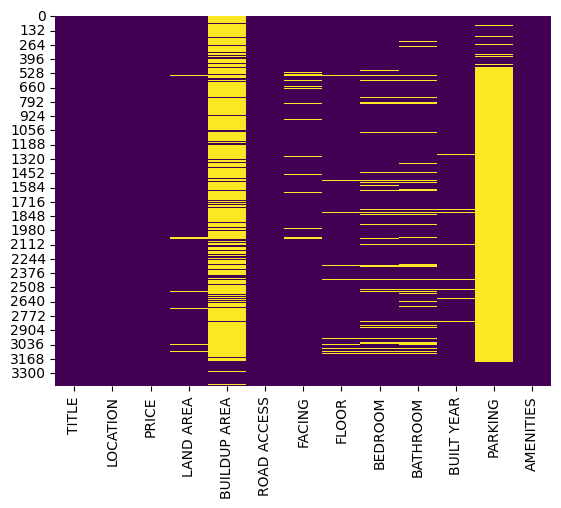

In [7]:
sns.heatmap(df.isna(), cmap='viridis', cbar=False)
plt.show()

In [8]:
df.drop(columns=['PARKING'], inplace=True)
df.drop(columns=['BUILDUP AREA'], inplace=True)
df.drop(columns=['AMENITIES'], inplace=True)
df.drop(columns=['TITLE'], inplace=True)

In [9]:
# Custom Functions for Data Cleaning

def convert_price(price_str, land_area):
    if not price_str:
        return np.nan

    # Remove the "Rs." prefix and extra spaces
    cleaned = price_str.replace("Rs.", "").strip()
    
    # Return NaN for non-numeric or known non-price texts
    if not re.search(r'\d', cleaned) or cleaned.lower() == "price on call":
        return np.nan

    # Default multiplier is 1
    multiplier = 1
    cleaned_lower = cleaned.lower()

    # Handle Crore and Lac multipliers
    if 'cr' in cleaned_lower:
        multiplier = 10000000
        cleaned = re.sub(r'cr', '', cleaned, flags=re.IGNORECASE).strip()
    elif 'lac' in cleaned_lower:
        multiplier = 100000
        cleaned = re.sub(r'lac', '', cleaned, flags=re.IGNORECASE).strip()
    
    # Determine if price is per aana or per square meter
    per_aana = "/aana" in cleaned_lower
    per_m2 = any(x in cleaned_lower for x in ["/m", "/m²", "/m sq", "/sq.m"])
    
    # Remove unit markers (/aana, /m, etc.) from the cleaned price string
    cleaned = re.sub(r"/aana|/m|/m²|/m sq|/sq\.m", "", cleaned, flags=re.IGNORECASE).strip()
    cleaned = cleaned.replace(",", "")
    
    # Extract the numeric value from the price string
    match = re.search(r"[\d\.]+", cleaned)
    if not match:
        return np.nan
    try:
        value = float(match.group(0)) * multiplier
    except ValueError:
        return np.nan

    # Extract numeric value from land_area
    land_area_match = re.search(r"[\d\.]+", str(land_area))
    if land_area_match:
        land_area_numeric = float(land_area_match.group(0))
    else:
        land_area_numeric = np.nan

    # If land area is missing, just return the price value
    if np.isnan(land_area_numeric):
        return value

    # Conversion factor: 1 aana ≈ 31.8 m²
    conversion_factor = 31.8

    # Calculate total price based on unit type:
    if per_aana:
        # LAND AREA is assumed to be in aana already.
        total_price = value * land_area_numeric
    elif per_m2:
        # For price per square meter, first convert:
        #  - Effective price per aana = price per m² * conversion factor.
        #  - Convert LAND AREA from m² to aana.
        effective_price_per_aana = value * conversion_factor
        land_area_aana = land_area_numeric / conversion_factor
        total_price = effective_price_per_aana * land_area_aana
    else:
        # If no per-unit is detected, assume the price is total.
        total_price = value

    return total_price

def remove_bs(date):
    if not date:
        return np.nan
    if isinstance(date, float):
        return date
    date_cleaned = date.replace("B.S", "").strip()
    try:
        value = int(date_cleaned)
        return value
    except ValueError:
        return np.nan
    return date_cleaned

def convert_to_feet(data):
    if not isinstance(data, str) or 'meter' in data.lower():  # Ignore non-string & 'meter' values
        return np.nan
    
    # Remove all variations of "feet" and strip spaces
    data_cleaned = re.sub(r"\s?(feet|ft|FT|'s|\")\s?", "", data, flags=re.IGNORECASE).strip()
    
    # Handle ranges (e.g., "12-15", "12/20") by taking the average
    if "-" in data_cleaned or "/" in data_cleaned:
        numbers = re.findall(r"\d+\.?\d*", data_cleaned)  # Extract all numbers
        if len(numbers) == 2:  # If exactly two numbers exist
            return int(round((float(numbers[0]) + float(numbers[1])) / 2))  # Average and round
    
    # Handle single numeric values
    try:
        return int(round(float(data_cleaned)))  # Convert and round to nearest int
    except ValueError:
        return np.nan  # Return NaN if invalid

def convert_to_aana(value):
    if pd.isna(value) or str(value).strip() == '':
        return None  # Handle missing values
    
    value = str(value).lower().strip()  # Normalize text
    match = re.findall(r"[\d\.\+]+", value)  # Extract numbers
    
    if not match:
        return None  # If no valid number is found, return None
    
    try:
        num = sum(map(float, match))  # Convert and sum in case of "2600+1600 sq. ft"
        
        if "aana" in value:
            return num  # Already in Aana, just clean up
        
        elif "kattha" in value:
            return num * 20  # Convert Kattha to Aana
        
        elif "sq. ft" in value:
            return num * 0.000729  # Convert Sq. Ft to Aana
        
        elif "sq. mtr" in value or "sq. meter" in value:
            return num * 10.764 * 0.000729  # Convert Sq. Mtr to Aana
        
        else:
            return num  # If unknown, return the extracted number as-is
    
    except ValueError:
        return None  # If conversion fails, return None

In [10]:
# Converting Land Area into Aana Units
df['LAND AREA'] = df['LAND AREA'].apply(convert_to_aana)

In [11]:
# Converting Price into Rs and also removing not convertable
df['PRICE'] = df.apply(lambda row: convert_price(row['PRICE'], row['LAND AREA']), axis=1)
df = df.dropna(subset=['PRICE'])
df['PRICE'] = df['PRICE'].astype(int)

In [12]:
#Remove B.S in Bulit Year
df['BUILT YEAR'] = df['BUILT YEAR'].apply(remove_bs)

In [13]:
# Converting Road Access into Feet Units
df['ROAD ACCESS'] = df['ROAD ACCESS'].apply(convert_to_feet)

In [14]:
# COnvertinf Facing into lowercase
df['FACING'] = df['FACING'].str.replace(r'\s|-|/', ' ', regex=True).str.strip().str.lower()

# Standardize direction combinations (e.g., 'west north' should become 'north west')
df['FACING'] = df['FACING'].replace({'west north': 'north west', 'west south': 'south west',
                                      'north  east': 'north east', 'east south': 'south east',
                                      'west south': 'south west', 'east north': 'north east',
                                      'east west': 'west east'}, regex=True)

In [15]:
print("Missing Values Before Imputation:\n", df.isnull().sum())

Missing Values Before Imputation:
 LOCATION         0
PRICE            0
LAND AREA      107
ROAD ACCESS     17
FACING         177
FLOOR           81
BEDROOM        257
BATHROOM       319
BUILT YEAR      56
dtype: int64


In [16]:
#  Fill Numerical Columns with Median
num_cols = ['LAND AREA', 'ROAD ACCESS', 'FLOOR', 'BEDROOM', 'BATHROOM', 'BUILT YEAR']
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

In [17]:
df['FACING'] = df['FACING'].fillna('missing')

In [18]:
print("Missing Values After Imputation:\n", df.isnull().sum())

Missing Values After Imputation:
 LOCATION       0
PRICE          0
LAND AREA      0
ROAD ACCESS    0
FACING         0
FLOOR          0
BEDROOM        0
BATHROOM       0
BUILT YEAR     0
dtype: int64


In [19]:
df['FLOOR'] = df['FLOOR'].astype(float)
df['BEDROOM'] = df['BEDROOM'].astype(int)
df['BUILT YEAR'] = df['BUILT YEAR'].astype(int)
df['BATHROOM'] = df['BATHROOM'].astype(int)
df['ROAD ACCESS'] = df['ROAD ACCESS'].astype(int)
df.rename(columns={'PRICE': 'Price', 'LAND AREA': 'Land Area (Aana)', 'ROAD ACCESS': 'Road Access (Feet)'}, inplace=True)

In [20]:
# # Convert the string representation of lists to actual lists
# df['AMENITIES'] = df['AMENITIES'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# # Now explode the amenities into individual values
# all_amenities = df['AMENITIES'].explode().dropna()

# # Count occurrences of each amenity
# amenity_counts = Counter(all_amenities)

# # Display the 4 most common amenities
# print(amenity_counts.most_common(4))

## 1.3 Exploratory Data Aanalysis 

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


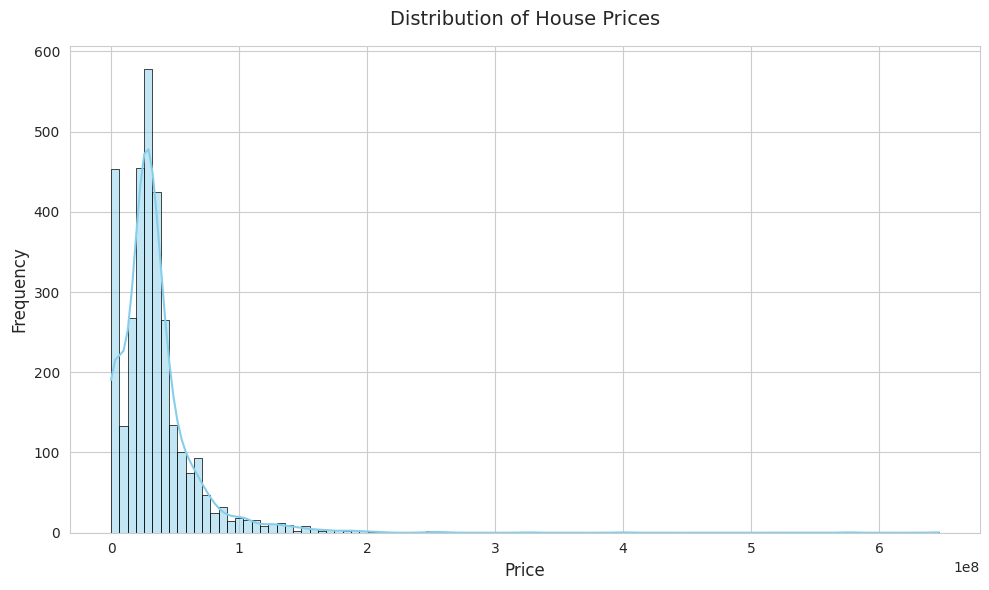

In [21]:
# Set the style for better aesthetics
sns.set_style("whitegrid")  # Optional: Use "darkgrid", "white", or "ticks" for different styles

# Create the histogram with a KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))  # Set figure size for better readability
sns.histplot(data=df['Price'], bins=100, kde=True, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of House Prices', fontsize=14, pad=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

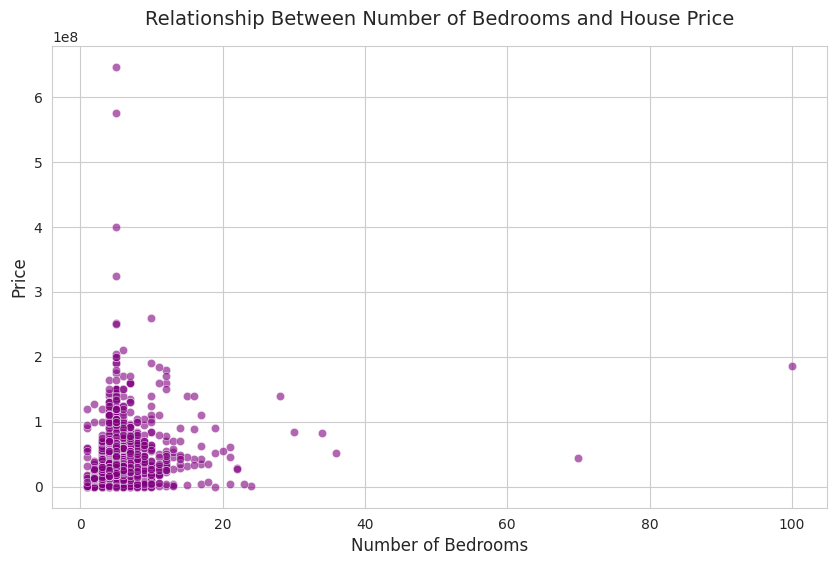

In [22]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set figure size
sns.scatterplot(x="BEDROOM", y="Price", data=df, color='purple', alpha=0.6)

# Add labels and title
plt.title('Relationship Between Number of Bedrooms and House Price', fontsize=14, pad=15)
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)


# Show the plot
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


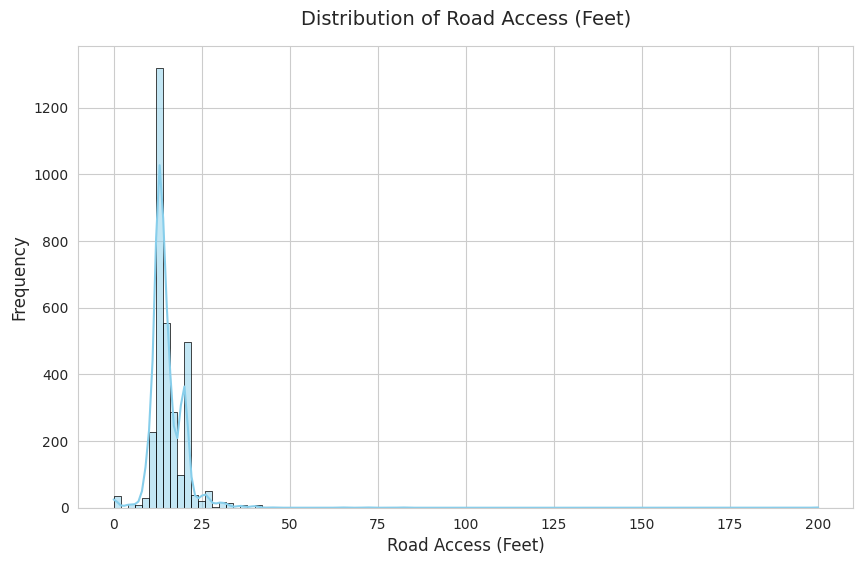

In [23]:
plt.figure(figsize=(10, 6))  # Set figure size
sns.histplot(data=df['Road Access (Feet)'], bins=100, kde=True, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of Road Access (Feet)', fontsize=14, pad=15)
plt.xlabel('Road Access (Feet)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


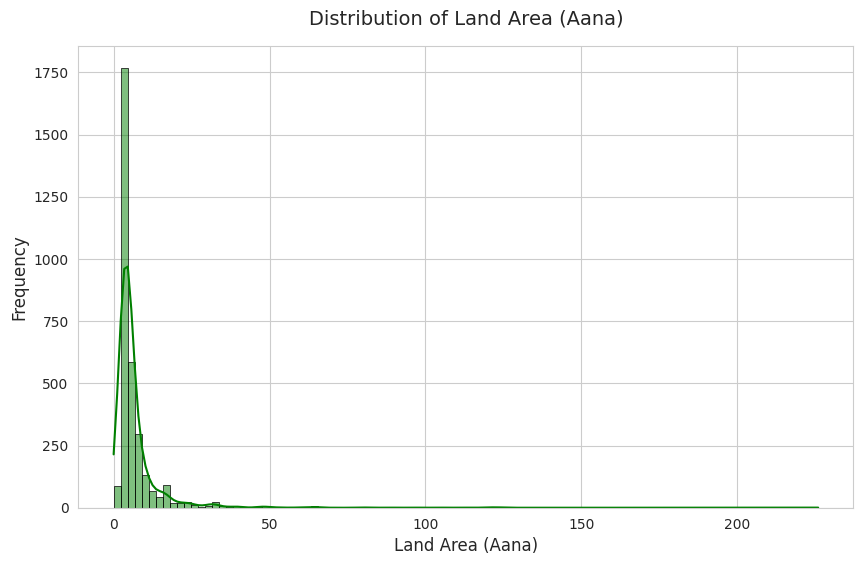

In [24]:
# Create the histogram with KDE
plt.figure(figsize=(10, 6))  # Set figure size
sns.histplot(data=df['Land Area (Aana)'], bins=100, kde=True, color='green', edgecolor='black')

# Add labels and title
plt.title('Distribution of Land Area (Aana)', fontsize=14, pad=15)
plt.xlabel('Land Area (Aana)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)


# Show the plot
plt.show()

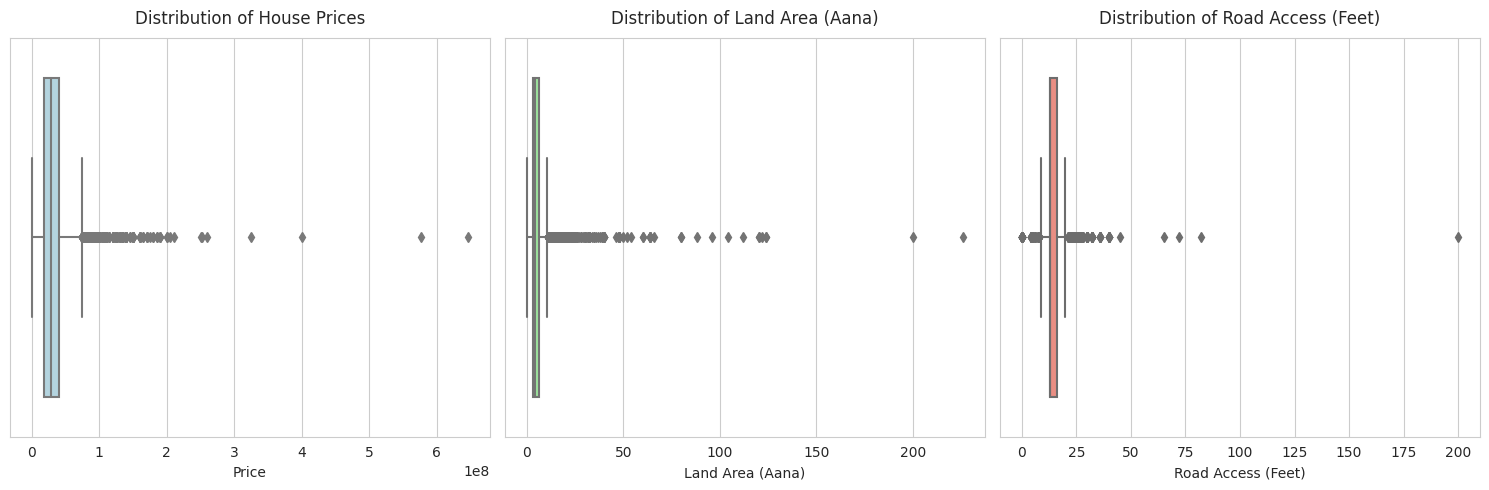

In [25]:
# Create a figure with subplots for all three box plots
plt.figure(figsize=(15, 5))  # Larger figure to accommodate three plots side by side

# 1. Box plot for Price
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
sns.boxplot(x=df['Price'], color='lightblue')
plt.title('Distribution of House Prices', fontsize=12, pad=10)
plt.xlabel('Price', fontsize=10)

# 2. Box plot for Land Area (Aana)
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
sns.boxplot(x=df['Land Area (Aana)'], color='lightgreen')
plt.title('Distribution of Land Area (Aana)', fontsize=12, pad=10)
plt.xlabel('Land Area (Aana)', fontsize=10)

# 3. Box plot for Road Access (Feet)
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
sns.boxplot(x=df['Road Access (Feet)'], color='salmon')
plt.title('Distribution of Road Access (Feet)', fontsize=12, pad=10)
plt.xlabel('Road Access (Feet)', fontsize=10)

# Adjust layout to prevent label cutoff and ensure proper spacing
plt.tight_layout()

# Show the plot
plt.show()

# 2. Data Preprocessing and Feature Engineering

## 2.1 Handling Outliers

In [26]:
# Outlier detection and removal using IQR method for numerical features
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    
num_cols = ['Land Area (Aana)', 'FLOOR', 'Road Access (Feet)', 'BEDROOM', 'BATHROOM']
# Apply outlier removal for each numerical column
for col in num_cols:
    df = remove_outliers(df, col)

print("Dataset Shape After Outlier Removal:", df.shape)

Dataset Shape After Outlier Removal: (1589, 9)


In [27]:
# Calculate IQR (Interquartile Range)
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
outliers.head()

,LOCATION,Price,Land Area (Aana),Road Access (Feet),FACING,FLOOR,BEDROOM,BATHROOM,BUILT YEAR
14,"Bhaisepati, Lalitpur",65000000,6.2,12,south east,2.5,4,5,2077
20,"Dhapasi, Kathmandu",133000000,9.6,14,north east,2.5,5,5,2077
25,"Sanepa, Lalitpur",63500000,5.0,10,north west,2.5,5,3,2078
35,"Sanepa, Lalitpur",77500000,9.0,20,south west,2.5,5,5,2078
265,"Sanepa, Lalitpur",90000000,7.2,13,south,2.5,6,4,2079


In [28]:
df['Price'] = np.log1p(df['Price'])
df['Price'] = winsorize(df['Price'], limits=[0.10, 0.10])  # Cap top/bottom 10%

## 2.2 Feature Selection and Creation

In [29]:
# Split the 'LOCATION' column into 'Street' and 'District'
df[['Street', 'District']] = df['LOCATION'].str.split(',', expand=True)

# Trim any extra spaces
df['Street'] = df['Street'].str.strip().str.lower()
df['District'] = df['District'].str.strip().str.lower()

# Replace missing or None values in 'District' with 'missing'
df['District'] = df['District'].fillna('missing')

df.drop(columns=['LOCATION'], inplace=True)

In [30]:
df['Street'].unique()

array(['imadol', 'bhaisepati', 'budhanilkantha', 'kharibot', 'khumaltar',
       'dhapasi', 'sanepa', 'sunakothi', 'kapan', 'dhobighat',
       'sitapaila', 'hattiban', 'nakhipot', 'gwarko', 'baneshwor',
       'tokha', 'nakkhu', 'sukedhara', 'setipakha', 'tikathali', 'lubhu',
       'swoyambhu', 'baluwatar', 'nil barahi mandir', 'harisiddhi',
       'balkot', 'bageshwori', 'bhangal', 'samakhusi', 'hepali height',
       'bojepokhari', 'hattigaunda', 'thaiba', 'lasuntar', 'sanagaun',
       'samakhushi chowk', 'sundarbasti', 'katunje', 'chabahil',
       'naya bazar', 'grande villa', 'bansbari', 'pasikot', 'banasthali',
       'phutung', 'gurjudhara', 'balkumari', 'gongabu', 'balkhu',
       'grande hospital', 'satdobato', 'lalitpur', 'mulpani', 'bafal',
       'dakshindhoka', 'mhaipi', 'khichapokhari', 'dadhikot',
       'mandikhatar', 'satungal', 'maharajgunj', 'deuwa chowk',
       'mid baneshwor', 'narayanthan', 'greenhill city', 'thali',
       'jorpati', 'pepsicola', 'baluwakhani

In [31]:
# Dictionary of typos to correct values
typo_corrections = {
    'swoyambhu': 'swayambhu',
    'budhanikantha': 'budhanilkantha',
    'gokarneswhor': 'gokarneshwor',
    'nagajung': 'nagarjun',
    'nagarjung': 'nagarjun',
    'nagarjung-3': 'nagarjun',
    'chandagiri': 'chandragiri',
    'hattigauda': 'hatigauda',
    'hatti gauda': 'hatigauda',
    'sitapiala': 'sitapaila',
    'sita-paila': 'sitapaila',
    'sitapaila-5': 'sitapaila',
    'sano bhanrayang': 'sano bharyang',
    'sano bharayang': 'sano bharyang',
    'sano-bharyang': 'sano bharyang',
    'raamkot': 'ramkot',
    'gairgaun': 'gairigaun',
    'boudha': 'bouddha',
    'chauni': 'chhauni',
    'sorakhutee': 'sorakhutte',
    'ochu height': 'ochu heights',
    'hepali height': 'hepali heights',
    'suryadars.han height': 'suryadarsan heights',
    'undefined': 'missing',
    'nakhu': 'nakkhu',  
    'naicap': 'naikap'
}

# Replace typos in the 'Street' column
df['Street'] = df['Street'].replace(typo_corrections)

# Optional: Convert to lowercase for consistency
df['Street'] = df['Street'].str.lower()

In [32]:
df['District'].unique()

array(['lalitpur', 'kathmandu', 'bhaktapur', 'missing', 'chitwan',
       'kaski', 'morang', 'kavrepalanchok', 'jhapa', 'dhading',
       'sitapaila', 'kathmndu', 'rumba chowk', 'narayanthan',
       'kathmandhu'], dtype=object)

In [33]:
# Dictionary of typos to correct values
typo_corrections = {
    'karhmandu': 'kathmandu',
    'kathmndu': 'kathmandu',
    'kathmandhu': 'kathmandu',
    'narayanthan': 'kathmandu',
    'sukedhara': 'kathmandu',
    'swoyambhu': 'kathmandu',
    'sitapaila': 'kathmandu',
    'rumba chowk': 'kathmandu',
    'imadol': 'lalitpur',
}
# Replace typos in the 'District' column
df['District'] = df['District'].replace(typo_corrections)

In [34]:
# Check the updated unique values
print(df['District'].unique())

['lalitpur' 'kathmandu' 'bhaktapur' 'missing' 'chitwan' 'kaski' 'morang'
 'kavrepalanchok' 'jhapa' 'dhading']


In [35]:
# # Convert string representation of lists into actual lists
# df['AMENITIES'] = df['AMENITIES'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# # Extract all unique amenities
# all_amenities = set(amenity for sublist in df['AMENITIES'] for amenity in sublist)

# # Create a column for each unique amenity with binary values (1 if present, 0 otherwise)
# for amenity in all_amenities:
#     df[amenity] = df['AMENITIES'].apply(lambda x: 1 if amenity in x else 0)


In [36]:
df['House Age'] = 2081 - df['BUILT YEAR']
df.drop('BUILT YEAR', axis=1, inplace=True)

## 2.3 Exploratory Data Analysis 2

In [37]:
df.groupby('District')['Price'].median().sort_values(ascending=False)

District
bhaktapur         17.233103
kathmandu         17.210019
lalitpur          17.129697
morang            16.993564
kaski             16.972511
chitwan           16.811243
missing           16.785596
kavrepalanchok    16.770299
jhapa             16.523561
dhading           16.300417
Name: Price, dtype: float64

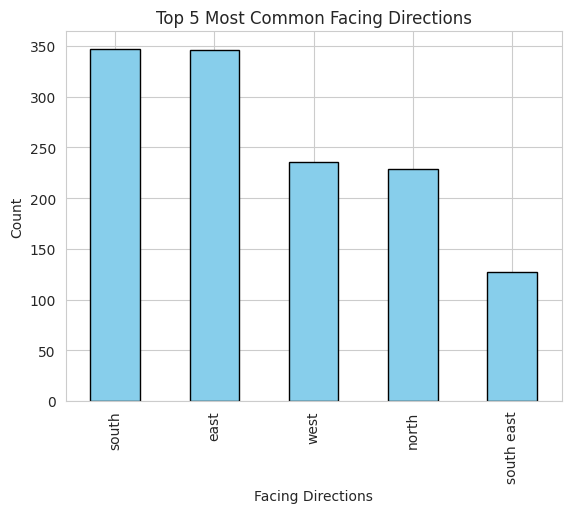

In [38]:
# Get the top 5 most frequent values in the 'FACING' column
top_5_facing = df['FACING'].value_counts().head(5)

# Plot the bar chart for the top 5 values
top_5_facing.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title to the plot
plt.title('Top 5 Most Common Facing Directions')
plt.xlabel('Facing Directions')
plt.ylabel('Count')

# Display the plot
plt.show()

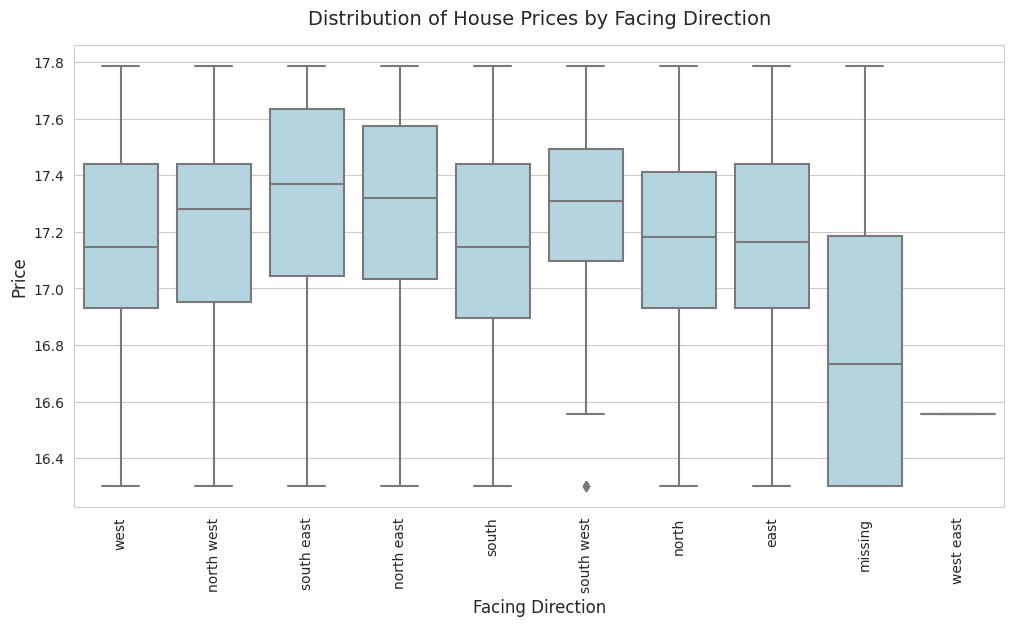

In [39]:
# Create the box plot
plt.figure(figsize=(12, 6))  # Set figure size
sns.boxplot(x="FACING", y="Price", data=df, color='lightblue')

# Add labels and title
plt.title('Distribution of House Prices by Facing Direction', fontsize=14, pad=15)
plt.xlabel('Facing Direction', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)


# Show the plot
plt.show()

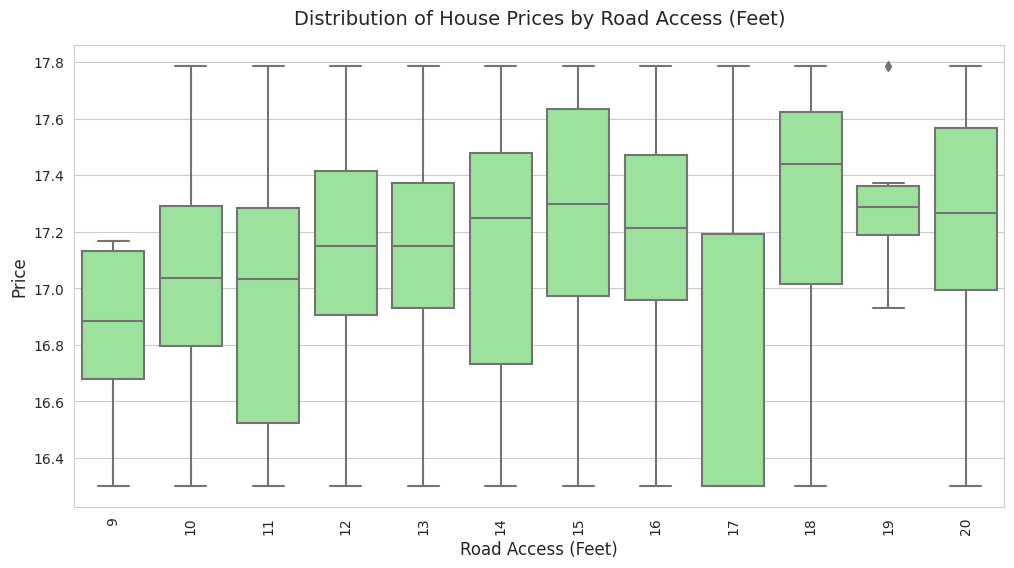

In [40]:
# Create the box plot
plt.figure(figsize=(12, 6))  # Set figure size
sns.boxplot(x="Road Access (Feet)", y="Price", data=df, color='lightgreen')

# Add labels and title
plt.title('Distribution of House Prices by Road Access (Feet)', fontsize=14, pad=15)
plt.xlabel('Road Access (Feet)', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)


# Show the plot
plt.show()

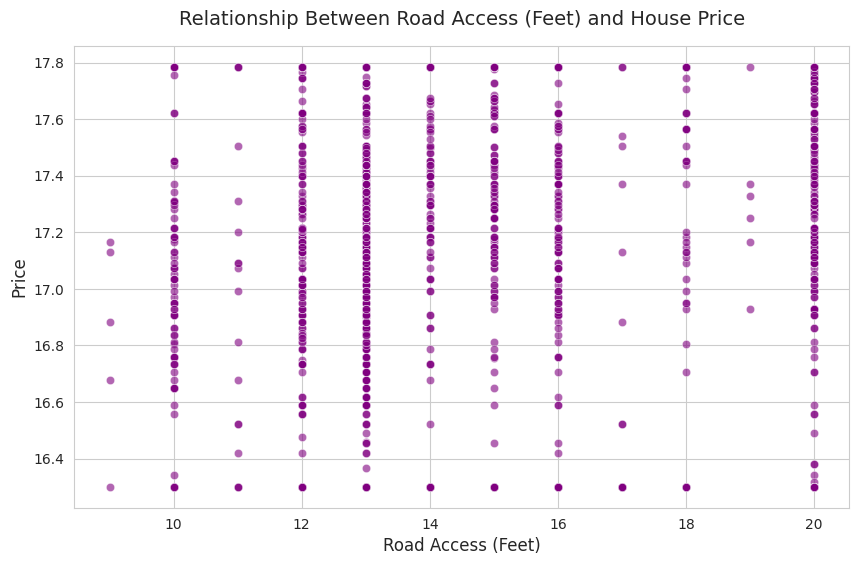

In [41]:
plt.figure(figsize=(10, 6))  # Set figure size
sns.scatterplot(x=df["Road Access (Feet)"], y=df["Price"], color='purple', alpha=0.6)

# Add labels and title
plt.title('Relationship Between Road Access (Feet) and House Price', fontsize=14, pad=15)
plt.xlabel('Road Access (Feet)', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Show the plot
plt.show()

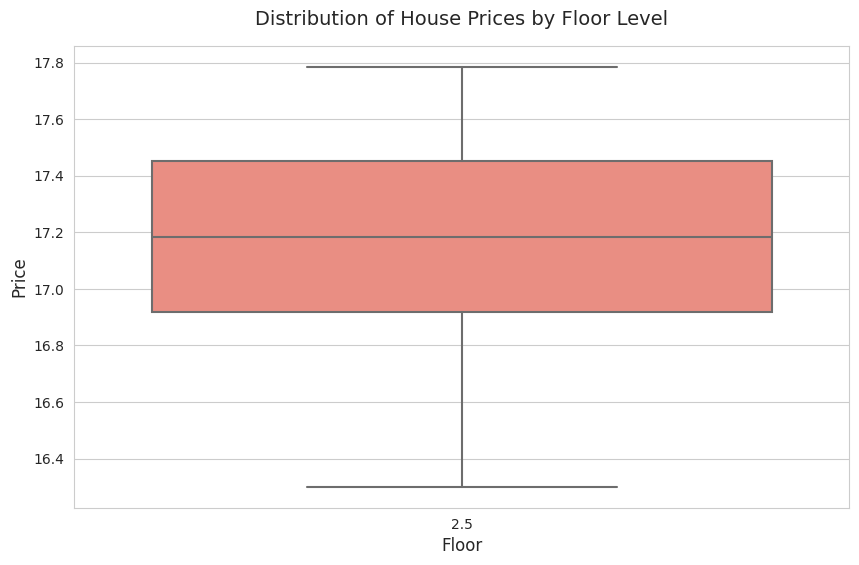

In [42]:
# Create the box plot
plt.figure(figsize=(10, 6))  # Set figure size
sns.boxplot(x="FLOOR", y="Price", data=df, color='salmon')

# Add labels and title
plt.title('Distribution of House Prices by Floor Level', fontsize=14, pad=15)
plt.xlabel('Floor', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Show the plot
plt.show()

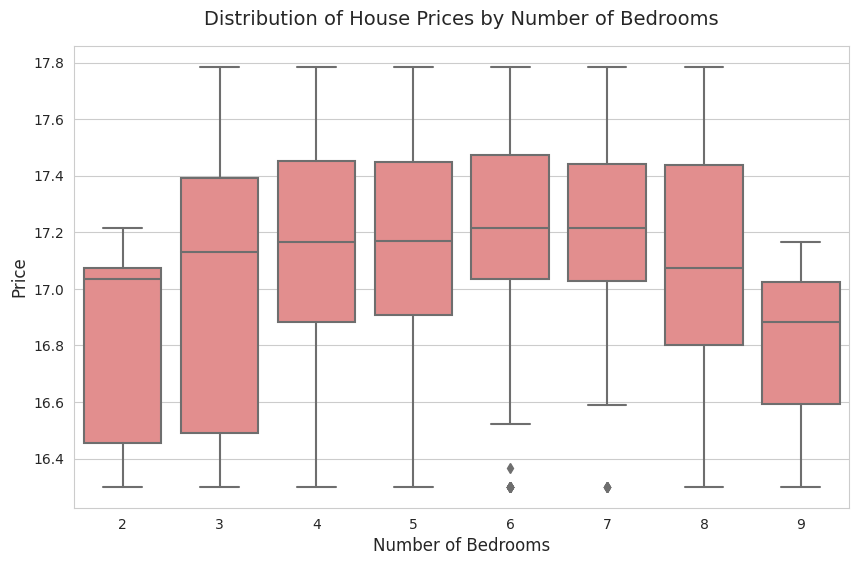

In [43]:
# Create the box plot
plt.figure(figsize=(10, 6))  # Set figure size
sns.boxplot(x="BEDROOM", y="Price", data=df, color='lightcoral')

# Add labels and title
plt.title('Distribution of House Prices by Number of Bedrooms', fontsize=14, pad=15)
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Show the plot
plt.show()

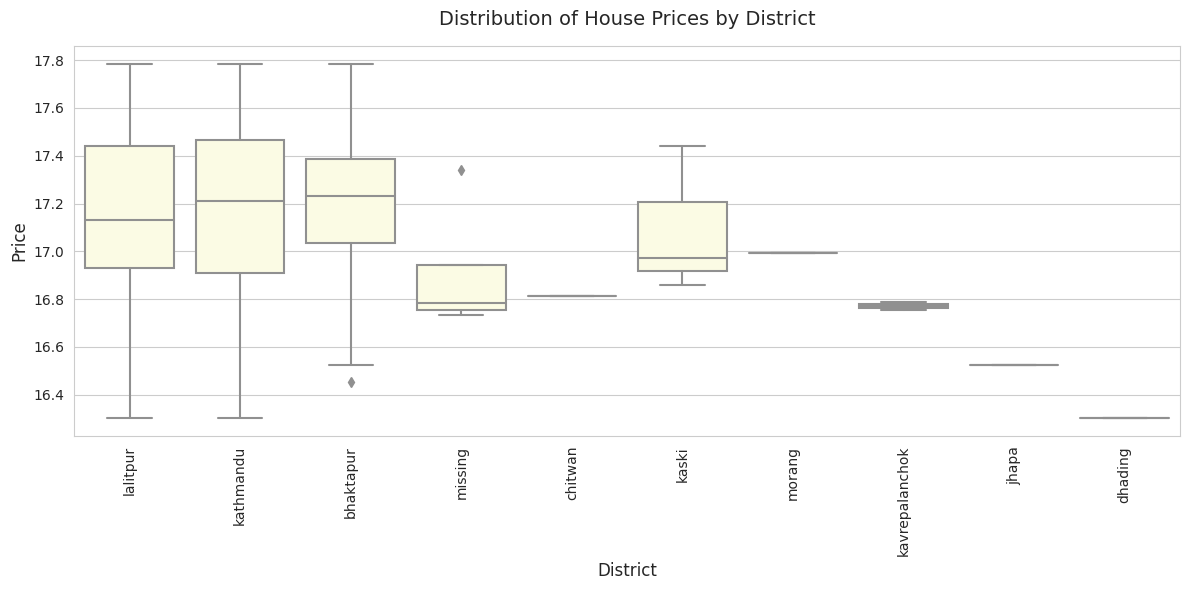

In [44]:
# Create the box plot
plt.figure(figsize=(12, 6))  # Set figure size
sns.boxplot(x="District", y="Price", data=df, color='lightyellow')

# Add labels and title
plt.title('Distribution of House Prices by District', fontsize=14, pad=15)
plt.xlabel('District', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

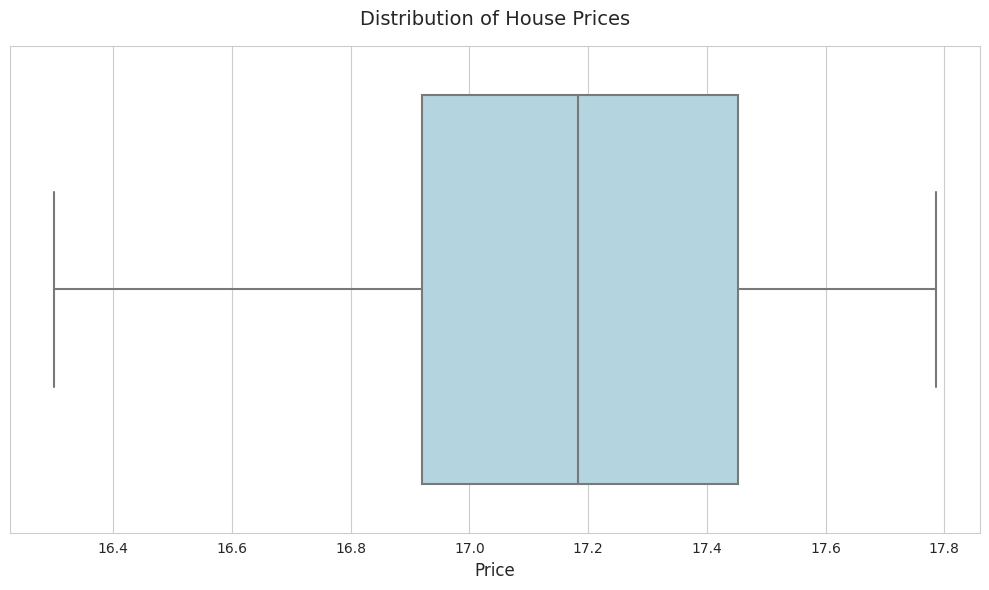

In [45]:

# Create the box plot
plt.figure(figsize=(10, 6))  # Set figure size
sns.boxplot(x=df['Price'], color='lightblue')

# Add labels and title
plt.title('Distribution of House Prices', fontsize=14, pad=15)
plt.xlabel('Price', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


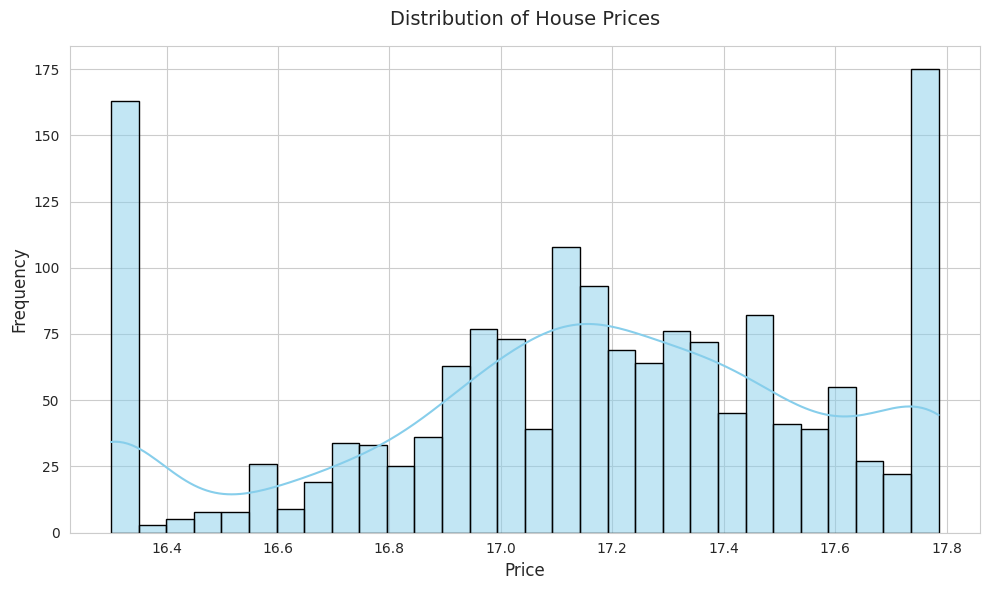

In [46]:
# Create the histogram with KDE
plt.figure(figsize=(10, 6))  # Set figure size
sns.histplot(data=df['Price'], bins=30, kde=True, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of House Prices', fontsize=14, pad=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

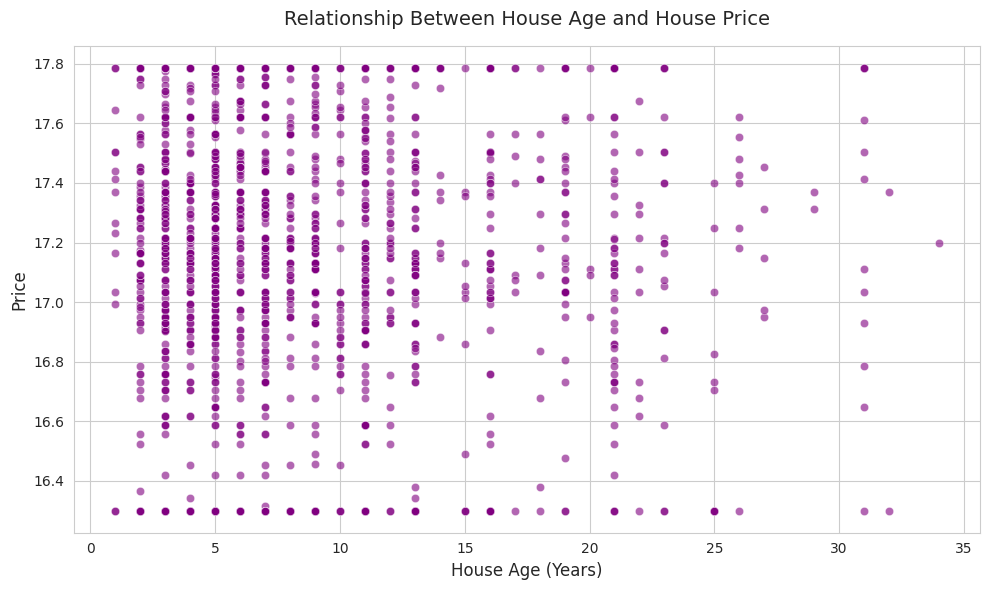

In [47]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set figure size
sns.scatterplot(x="House Age", y="Price", data=df, color='purple', alpha=0.6)

# Add labels and title
plt.title('Relationship Between House Age and House Price', fontsize=14, pad=15)
plt.xlabel('House Age (Years)', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

## 2.4 Feature Encoding

In [48]:
# Calculate mean target value for each unique street
district_mean = df.groupby('District')['Price'].mean()

# Map the mean values back to the 'District' column
df['District'] = df['District'].map(district_mean)

In [49]:
# Calculate mean target value for each unique street
street_mean = df.groupby('Street')['Price'].mean()

# Map the mean values back to the 'Street' column
df['Street'] = df['Street'].map(street_mean)

In [50]:
# Handle missing values and lowercase the 'FACING' column
df['FACING'] = df['FACING'].fillna('missing').str.lower()

# Calculate the mean of the target variable ('Price') for each 'FACING' value
target_mean = df.groupby('FACING')['Price'].mean()

df['FACING'] = df['FACING'].map(target_mean)

# If there are unknown values, fill them with the global mean of 'Price'
global_mean = df['Price'].mean()
df['FACING'] = df['FACING'].fillna(global_mean)

invalid value encountered in less


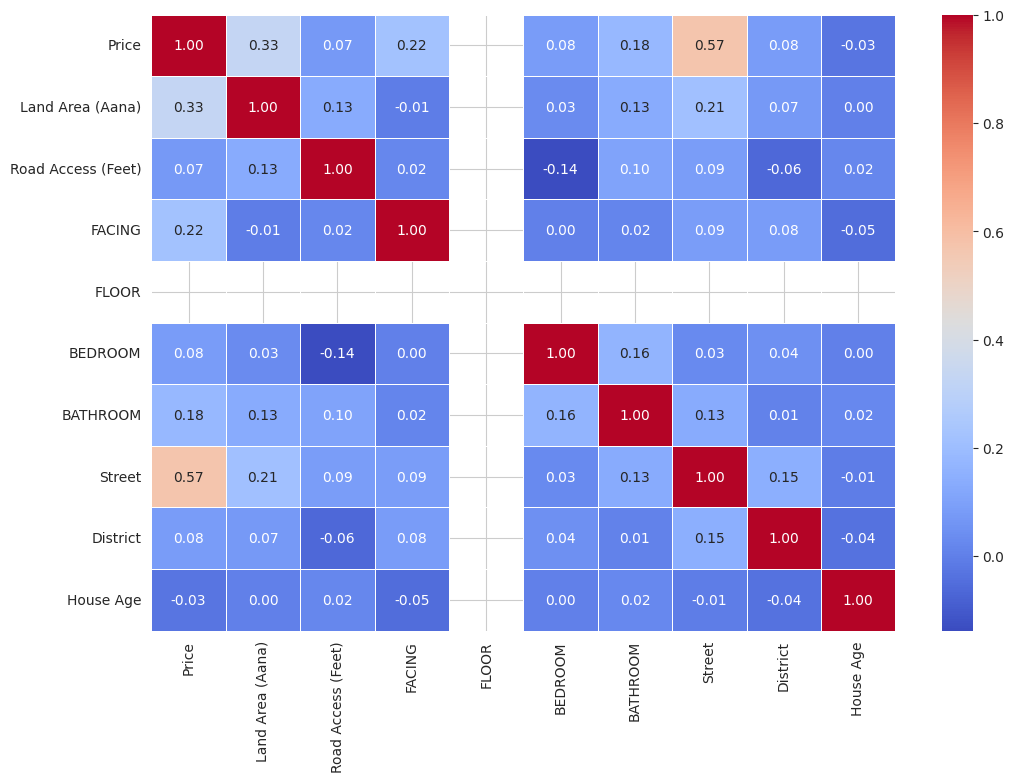

In [51]:
# Plot the correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


# Splitting the dataset

In [52]:
# # Define target variable and feature set (Assuming 'Price' is the target)
target = 'Price'
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)

Training Features Shape: (1271, 9)
Test Features Shape: (318, 9)


# 3) Model Development and Evaluation

## Linear Regression

In [53]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Loop through each fold in the KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    lr_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = lr_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
mse_scores = np.array(mse_scores)
mae_scores = np.array(mae_scores)
r2_scores = np.array(r2_scores)
rmse_scores = np.array(rmse_scores)

# Print results
print(f"Cross-Validation MSE scores: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean()}")
print(f"Standard Deviation of MSE: {mse_scores.std()}")
print(f"Mean MAE: {mae_scores.mean()}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Mean R² Score: {r2_scores.mean()}")


Cross-Validation MSE scores: [0.10841666 0.10557229 0.11338776 0.11562932 0.09886218]
Mean MSE: 0.10837364224940256
Standard Deviation of MSE: 0.005934702786877529
Mean MAE: 0.23405348629649514
Mean RMSE: 0.32907668506848103
Mean R² Score: 0.41473532526290596


## XGBoost Regressor

In [54]:
# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Loop through each fold in the KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = xgb_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
mse_scores = np.array(mse_scores)
mae_scores = np.array(mae_scores)
r2_scores = np.array(r2_scores)
rmse_scores = np.array(rmse_scores)

# Print results
print(f"Cross-Validation MSE scores: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean()}")
print(f"Standard Deviation of MSE: {mse_scores.std()}")
print(f"Mean MAE: {mae_scores.mean()}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Mean R² Score: {r2_scores.mean()}")


Cross-Validation MSE scores: [0.13208272 0.12710253 0.15661782 0.14241876 0.13991397]
Mean MSE: 0.13962716122763802
Standard Deviation of MSE: 0.010102900054043094
Mean MAE: 0.2602985182552363
Mean RMSE: 0.3734261686716302
Mean R² Score: 0.24709361529771087


## Random Forest

In [55]:
# Initialize the RandomForest model
rf_model = RandomForestRegressor(random_state=42)

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
rf_mse_scores = []
rf_mae_scores = []
rf_r2_scores = []
rf_rmse_scores = []

# Loop through each fold in the KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = rf_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    rf_mse_scores.append(mse)
    rf_mae_scores.append(mae)
    rf_r2_scores.append(r2)
    rf_rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
rf_mse_scores = np.array(rf_mse_scores)
rf_mae_scores = np.array(rf_mae_scores)
rf_r2_scores = np.array(rf_r2_scores)
rf_rmse_scores = np.array(rf_rmse_scores)

# Print results for RandomForest
print("Random Forest Model:")
print(f"Cross-Validation MSE scores: {rf_mse_scores}")
print(f"Mean MSE: {rf_mse_scores.mean()}")
print(f"Standard Deviation of MSE: {rf_mse_scores.std()}")
print(f"Mean MAE: {rf_mae_scores.mean()}")
print(f"Mean RMSE: {rf_rmse_scores.mean()}")
print(f"Mean R² Score: {rf_r2_scores.mean()}")


Random Forest Model:
Cross-Validation MSE scores: [0.11343808 0.10885671 0.12072554 0.11919254 0.11166577]
Mean MSE: 0.1147757294288954
Standard Deviation of MSE: 0.004503429523904651
Mean MAE: 0.23339969224738272
Mean RMSE: 0.3387205872259549
Mean R² Score: 0.3800144782392712


## CatBoost Regressor

In [56]:
# Initialize the CatBoost model
cat_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_state=42, verbose=0)

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
cat_mse_scores = []
cat_mae_scores = []
cat_r2_scores = []
cat_rmse_scores = []

# Loop through each fold in the KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    cat_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = cat_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    cat_mse_scores.append(mse)
    cat_mae_scores.append(mae)
    cat_r2_scores.append(r2)
    cat_rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
cat_mse_scores = np.array(cat_mse_scores)
cat_mae_scores = np.array(cat_mae_scores)
cat_r2_scores = np.array(cat_r2_scores)
cat_rmse_scores = np.array(cat_rmse_scores)

# Print results for CatBoost
print("CatBoost Model:")
print(f"Cross-Validation MSE scores: {cat_mse_scores}")
print(f"Mean MSE: {cat_mse_scores.mean()}")
print(f"Standard Deviation of MSE: {cat_mse_scores.std()}")
print(f"Mean MAE: {cat_mae_scores.mean()}")
print(f"Mean RMSE: {cat_rmse_scores.mean()}")
print(f"Mean R² Score: {cat_r2_scores.mean()}")


CatBoost Model:
Cross-Validation MSE scores: [0.11760234 0.12429796 0.12552668 0.12842272 0.1192449 ]
Mean MSE: 0.12301892120782813
Standard Deviation of MSE: 0.004017671814286376
Mean MAE: 0.24368723698425093
Mean RMSE: 0.3506936590721759
Mean R² Score: 0.33491055564751154


## Decision Tree Regressor

In [57]:

# Initialize the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
dt_mse_scores = []
dt_mae_scores = []
dt_r2_scores = []
dt_rmse_scores = []

# Loop through each fold in the KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    dt_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = dt_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    dt_mse_scores.append(mse)
    dt_mae_scores.append(mae)
    dt_r2_scores.append(r2)
    dt_rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
dt_mse_scores = np.array(dt_mse_scores)
dt_mae_scores = np.array(dt_mae_scores)
dt_r2_scores = np.array(dt_r2_scores)
dt_rmse_scores = np.array(dt_rmse_scores)

# Print results for Decision Tree
print("Decision Tree Model:")
print(f"Cross-Validation MSE scores: {dt_mse_scores}")
print(f"Mean MSE: {dt_mse_scores.mean()}")
print(f"Standard Deviation of MSE: {dt_mse_scores.std()}")
print(f"Mean MAE: {dt_mae_scores.mean()}")
print(f"Mean RMSE: {dt_rmse_scores.mean()}")
print(f"Mean R² Score: {dt_r2_scores.mean()}")


Decision Tree Model:
Cross-Validation MSE scores: [0.2202749  0.25479096 0.24570262 0.22320729 0.21487975]
Mean MSE: 0.23177110448974242
Standard Deviation of MSE: 0.015587305405460498
Mean MAE: 0.3135103349086647
Mean RMSE: 0.4811572345639882
Mean R² Score: -0.2531160743034312


## LightGBM Regressor

In [58]:

# Initialize the LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.1, random_state=42)

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
lgb_mse_scores = []
lgb_mae_scores = []
lgb_r2_scores = []
lgb_rmse_scores = []

# Loop through each fold in the KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    lgb_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = lgb_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    lgb_mse_scores.append(mse)
    lgb_mae_scores.append(mae)
    lgb_r2_scores.append(r2)
    lgb_rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
lgb_mse_scores = np.array(lgb_mse_scores)
lgb_mae_scores = np.array(lgb_mae_scores)
lgb_r2_scores = np.array(lgb_r2_scores)
lgb_rmse_scores = np.array(lgb_rmse_scores)

# Print results for LightGBM
print("LightGBM Model:")
print(f"Cross-Validation MSE scores: {lgb_mse_scores}")
print(f"Mean MSE: {lgb_mse_scores.mean()}")
print(f"Standard Deviation of MSE: {lgb_mse_scores.std()}")
print(f"Mean MAE: {lgb_mae_scores.mean()}")
print(f"Mean RMSE: {lgb_rmse_scores.mean()}")
print(f"Mean R² Score: {lgb_r2_scores.mean()}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1016, number of used features: 8
[LightGBM] [Info] Start training from score 17.147976
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1017, number of used features: 8
[LightGBM] [Info] Start training from score 17.153527
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

## Ridge Regression

In [59]:
# Initialize Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Alpha controls regularization strength

# Define KFold Cross-Validation (using 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
ridge_mse_scores = []
ridge_mae_scores = []
ridge_r2_scores = []
ridge_rmse_scores = []

# Loop through each fold in KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    ridge_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = ridge_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    ridge_mse_scores.append(mse)
    ridge_mae_scores.append(mae)
    ridge_r2_scores.append(r2)
    ridge_rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
ridge_mse_scores = np.array(ridge_mse_scores)
ridge_mae_scores = np.array(ridge_mae_scores)
ridge_r2_scores = np.array(ridge_r2_scores)
ridge_rmse_scores = np.array(ridge_rmse_scores)

# Print results for Ridge Regression
print("Ridge Regression Model:")
print(f"Mean MSE: {ridge_mse_scores.mean()}")
print(f"Mean MAE: {ridge_mae_scores.mean()}")
print(f"Mean RMSE: {ridge_rmse_scores.mean()}")
print(f"Mean R² Score: {ridge_r2_scores.mean()}")


Ridge Regression Model:
Mean MSE: 0.10846839509828729
Mean MAE: 0.23401067507138767
Mean RMSE: 0.3292072642116596
Mean R² Score: 0.414309340029188


## Lasso Regression

In [60]:
# Initialize Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # Alpha controls the sparsity

# Lists to store scores
lasso_mse_scores = []
lasso_mae_scores = []
lasso_r2_scores = []
lasso_rmse_scores = []

# Loop through each fold in KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the current fold's training data
    lasso_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = lasso_model.predict(X_val_fold)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    # Append scores to lists
    lasso_mse_scores.append(mse)
    lasso_mae_scores.append(mae)
    lasso_r2_scores.append(r2)
    lasso_rmse_scores.append(rmse)

# Convert lists to numpy arrays for easy calculations
lasso_mse_scores = np.array(lasso_mse_scores)
lasso_mae_scores = np.array(lasso_mae_scores)
lasso_r2_scores = np.array(lasso_r2_scores)
lasso_rmse_scores = np.array(lasso_rmse_scores)

# Print results for Lasso Regression
print("Lasso Regression Model:")
print(f"Mean MSE: {lasso_mse_scores.mean()}")
print(f"Mean MAE: {lasso_mae_scores.mean()}")
print(f"Mean RMSE: {lasso_rmse_scores.mean()}")
print(f"Mean R² Score: {lasso_r2_scores.mean()}")


Lasso Regression Model:
Mean MSE: 0.16866253080911
Mean MAE: 0.31743855841013346
Mean RMSE: 0.4104292379329012
Mean R² Score: 0.09067350649599666


## Average Ensembling Using top 6 models

In [61]:
# Get predictions from each model on the test set
rf_pred = rf_model.predict(X_test)
cat_pred = cat_model.predict(X_test)
lr_pred = lr_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
ridge_pred = ridge_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)

# Combine the predictions by taking a simple average
ensemble_pred = (rf_pred + cat_pred + lr_pred + xgb_pred  + ridge_pred + lgb_pred ) / 6.0

# Evaluate the ensemble's performance using various metrics
mse = mean_squared_error(y_test, ensemble_pred)
mae = mean_absolute_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)
rmse = np.sqrt(mse)

# Print the evaluation results
print("Simple Averaging Ensemble Performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Simple Averaging Ensemble Performance:
MSE: 0.1048
MAE: 0.2255
RMSE: 0.3237
R² Score: 0.4188


# 4) Model Interpretation and Explainability

  0%|          | 0/50 [00:00<?, ?it/s]

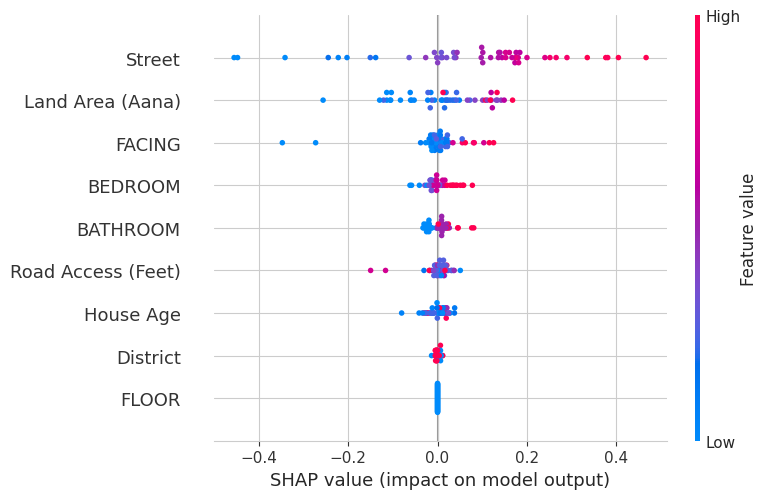

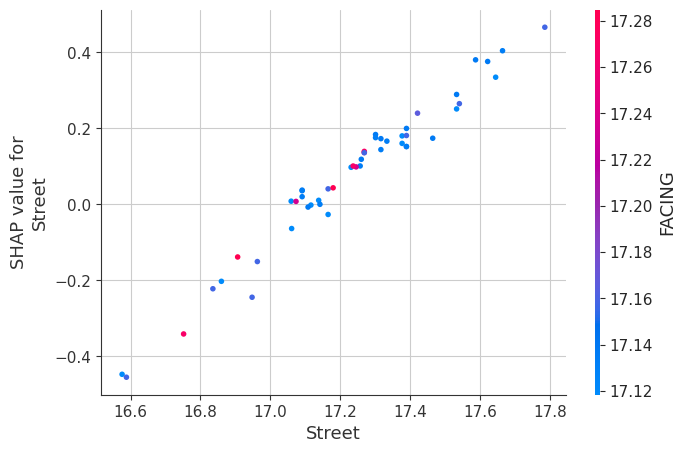

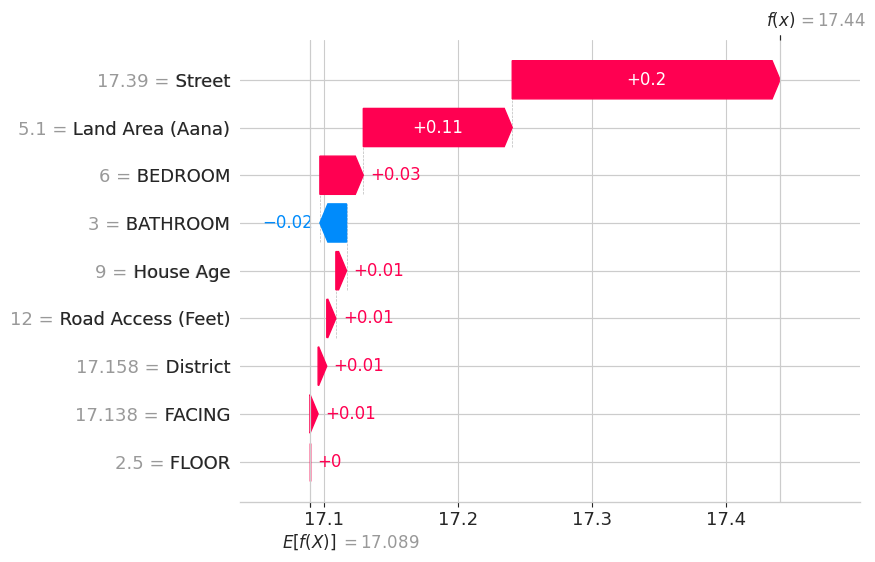

In [62]:
# ✅ Define the ensemble prediction function
def ensemble_predict(X):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=X_train.columns)  # Convert NumPy array to DataFrame
    
    # Make a fresh copy to avoid slicing issues in LightGBM
    X_lgb = X.copy()  

    # Predict using all models and take the average
    preds = (
        rf_model.predict(X) +
        cat_model.predict(X) +
        lr_model.predict(X) +
        xgb_model.predict(X) +
        ridge_model.predict(X) +
        lgb_model.predict(X_lgb)  # Use copied DataFrame for LightGBM
    ) / 6.0  
    
    return preds

# ================= SHAP ANALYSIS =================

# ✅ Select a background sample for KernelExplainer
background = X_train.sample(100, random_state=42)

# ✅ Create a SHAP KernelExplainer using the ensemble function
explainer = shap.KernelExplainer(ensemble_predict, background)

# ✅ Compute SHAP values for the first 50 test samples
shap_values = explainer.shap_values(X_test.iloc[:50])

# ✅ 1. SHAP Summary Plot (Feature Importance)
shap.summary_plot(shap_values, X_test.iloc[:50])

# ✅ 2. SHAP Dependence Plot for the top feature
top_feature = X_train.columns[np.argmax(np.abs(shap_values).mean(axis=0))]  # Most important feature
shap.dependence_plot(top_feature, shap_values, X_test.iloc[:50])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0], 
        base_values=explainer.expected_value,  # Add base values
        feature_names=X_test.columns,
        data=X_test.iloc[0].values  # Add actual feature values
    )
)


# ✅ 4. SHAP Force Plot for Local Interpretability (single prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# ================= LIME ANALYSIS =================

# ✅ Initialize LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns.tolist(), 
    class_names=['Price'], 
    mode='regression'
)

# ✅ Explain a single prediction (first test sample)
lime_exp = lime_explainer.explain_instance(X_test.iloc[0].values, ensemble_predict)

# ✅ 5. LIME Feature Importance Visualization
lime_exp.show_in_notebook()


# 5) Deployment Strategy and Considerations

In [63]:
import pickle

models = {
    "random_forest": rf_model,
    "catboost": cat_model,
    "linear_regression": lr_model,
    "xgboost": xgb_model,
    "ridge": ridge_model,
    "lightgbm": lgb_model
}

# Save each model separately
for name, model in models.items():
    with open(f"{name}.pkl", "wb") as f:
        pickle.dump(model, f)
